KNN original

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score
)
import pickle
from google.colab import drive, files

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
data_path = '/content/drive/MyDrive/Pairs_with_Similarity_Combined.csv'
data = pd.read_csv(data_path)

# Define X and y
X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
y = data['interaction']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tensor device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- K-Fold cross-validation -----
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

acc_list, f1_list, prec_list, rec_list = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y), 1):
    print(f"\n===== Fold {fold}/{k} =====")

    # Split
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

    # Define simple model
    class SimpleClassifier(nn.Module):
        def __init__(self, input_size, num_classes):
            super().__init__()
            self.fc = nn.Linear(input_size, num_classes)

        def forward(self, x):
            return self.fc(x)

    input_size = X_train_tensor.shape[1]
    num_classes = len(y.unique())

    model = SimpleClassifier(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train
    epochs = 100
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probs = torch.softmax(outputs, dim=1)
        y_pred = torch.argmax(probs, dim=1)

    # Metrics
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

    acc = accuracy_score(y_test_np, y_pred_np)
    f1 = f1_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
    prec = precision_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
    rec = recall_score(y_test_np, y_pred_np, average='weighted', zero_division=0)

    acc_list.append(acc)
    f1_list.append(f1)
    prec_list.append(prec)
    rec_list.append(rec)

    print(f"Fold {fold} — Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

# ----- Summary -----
results_dict = {
    "Method": "SimpleNN",
    "Accuracy_mean": np.mean(acc_list),
    "Accuracy_std": np.std(acc_list),
    "F1_mean": np.mean(f1_list),
    "F1_std": np.std(f1_list),
    "Precision_mean": np.mean(prec_list),
    "Precision_std": np.std(prec_list),
    "Recall_mean": np.mean(rec_list),
    "Recall_std": np.std(rec_list)
}

print("\n===== Final CV Results (mean ± std) =====")
for metric in ["Accuracy", "F1", "Precision", "Recall"]:
    print(f"{metric}: {results_dict[metric+'_mean']:.4f} ± {results_dict[metric+'_std']:.4f}")

# Save results
with open('classification_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

files.download('classification_results.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda

===== Fold 1/5 =====
Fold 1 — Acc: 0.7544, F1: 0.7470, Prec: 0.7459, Recall: 0.7544

===== Fold 2/5 =====
Fold 2 — Acc: 0.7603, F1: 0.7527, Prec: 0.7524, Recall: 0.7603

===== Fold 3/5 =====
Fold 3 — Acc: 0.7551, F1: 0.7476, Prec: 0.7469, Recall: 0.7551

===== Fold 4/5 =====
Fold 4 — Acc: 0.7532, F1: 0.7458, Prec: 0.7446, Recall: 0.7532

===== Fold 5/5 =====
Fold 5 — Acc: 0.7560, F1: 0.7487, Prec: 0.7476, Recall: 0.7560

===== Final CV Results (mean ± std) =====
Accuracy: 0.7558 ± 0.0024
F1: 0.7484 ± 0.0023
Precision: 0.7475 ± 0.0027
Recall: 0.7558 ± 0.0024


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN SMOTE

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
data_path = '/content/drive/MyDrive/Partially_Oversampled_Data.csv'
data = pd.read_csv(data_path)

# Define X and y
X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
y = data['interaction'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
all_accuracy, all_f1, all_precision, all_recall = [], [], [], []

fold = 1
for train_idx, test_idx in kf.split(X_scaled, y):
    print(f"\n🔹 Fold {fold}")
    fold += 1

    # Split data
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Convert to tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    # Model
    input_size = X_train_tensor.shape[1]
    num_classes = len(np.unique(y))
    model = SimpleNN(input_size, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train
    epochs = 50
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

    y_pred = preds.cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    all_accuracy.append(acc)
    all_f1.append(f1)
    all_precision.append(prec)
    all_recall.append(rec)

    print(f"Fold results -> Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

# Final results with mean ± std
results_summary = {
    "Accuracy": (np.mean(all_accuracy), np.std(all_accuracy)),
    "F1": (np.mean(all_f1), np.std(all_f1)),
    "Precision": (np.mean(all_precision), np.std(all_precision)),
    "Recall": (np.mean(all_recall), np.std(all_recall)),
}

print("\n Final Cross-Validation Results (mean ± std):")
for metric, (mean_val, std_val) in results_summary.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

# Save results to pickle
import pickle
with open('cv_results.pkl', 'wb') as f:
    pickle.dump({
        "all_accuracy": all_accuracy,
        "all_f1": all_f1,
        "all_precision": all_precision,
        "all_recall": all_recall,
        "results_summary": results_summary
    }, f)

from google.colab import files
files.download('cv_results.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-4188792646.py:22: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


Using device: cuda

🔹 Fold 1
Fold results -> Acc: 0.7414, F1: 0.7344, Prec: 0.7338, Recall: 0.7414

🔹 Fold 2
Fold results -> Acc: 0.7357, F1: 0.7278, Prec: 0.7266, Recall: 0.7357

🔹 Fold 3
Fold results -> Acc: 0.7357, F1: 0.7287, Prec: 0.7277, Recall: 0.7357

🔹 Fold 4
Fold results -> Acc: 0.7362, F1: 0.7289, Prec: 0.7275, Recall: 0.7362

🔹 Fold 5
Fold results -> Acc: 0.7378, F1: 0.7310, Prec: 0.7295, Recall: 0.7378

📊 Final Cross-Validation Results (mean ± std):
Accuracy: 0.7374 ± 0.0021
F1: 0.7302 ± 0.0024
Precision: 0.7290 ± 0.0025
Recall: 0.7374 ± 0.0021


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

XGBOOST original

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Load dataset
data_path = '/content/drive/MyDrive/Pairs_with_Similarity_Combined.csv'
data = pd.read_csv(data_path)

# Step 3: Define X and y
X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
y = data['interaction'].values

# Step 4: Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_accuracy, all_f1, all_precision, all_recall = [], [], [], []

fold = 1
for train_idx, test_idx in kf.split(X_scaled, y):
    print(f"\n🔹 Fold {fold}")
    fold += 1

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Convert to DMatrix
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_test, label=y_test)

    # Parameters
    params = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'max_depth': 6,
        'eta': 0.3,
        'eval_metric': 'mlogloss',
        'gpu_id': 0,
        'tree_method': 'gpu_hist'
    }

    # Train
    num_round = 50
    watchlist = [(train_dmatrix, 'train'), (test_dmatrix, 'eval')]
    model = xgb.train(params, train_dmatrix, num_boost_round=num_round, evals=watchlist, verbose_eval=False)

    # Predict
    y_pred_prob = model.predict(test_dmatrix)
    y_pred = y_pred_prob.argmax(axis=1)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    all_accuracy.append(acc)
    all_f1.append(f1)
    all_precision.append(prec)
    all_recall.append(rec)

    print(f"Fold results -> Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

# Step 6: Summary results
results_summary = {
    "Accuracy": (np.mean(all_accuracy), np.std(all_accuracy)),
    "F1": (np.mean(all_f1), np.std(all_f1)),
    "Precision": (np.mean(all_precision), np.std(all_precision)),
    "Recall": (np.mean(all_recall), np.std(all_recall)),
}

print("\n Final Cross-Validation Results (mean ± std):")
for metric, (mean_val, std_val) in results_summary.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

# Step 7: Save results
method_name = "XGBOOST"
results_dict = {
    "Method": method_name,
    "all_accuracy": all_accuracy,
    "all_f1": all_f1,
    "all_precision": all_precision,
    "all_recall": all_recall,
    "results_summary": results_summary
}

with open('cv_results_xgboost.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print("✅ Results exported to cv_results_xgboost.pkl")

# Step 8: Download
from google.colab import files
files.download('cv_results_xgboost.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🔹 Fold 1


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:30:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [01:38:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


Fold results -> Acc: 0.7677, F1: 0.7656, Prec: 0.7666, Recall: 0.7677

🔹 Fold 2


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:38:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [01:46:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


Fold results -> Acc: 0.7706, F1: 0.7675, Prec: 0.7695, Recall: 0.7706

🔹 Fold 3


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:46:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [01:54:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


Fold results -> Acc: 0.7669, F1: 0.7641, Prec: 0.7652, Recall: 0.7669

🔹 Fold 4


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:54:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [02:02:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


Fold results -> Acc: 0.7664, F1: 0.7634, Prec: 0.7646, Recall: 0.7664

🔹 Fold 5


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:02:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


XGBOOST smote

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Load dataset
data_path = '/content/drive/MyDrive/Partially_Oversampled_Data.csv'
data = pd.read_csv(data_path)

# Step 3: Define X and y
X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
y = data['interaction'].values

# Step 4: Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_accuracy, all_f1, all_precision, all_recall = [], [], [], []

fold = 1
for train_idx, test_idx in kf.split(X_scaled, y):
    print(f"\n🔹 Fold {fold}")
    fold += 1

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Convert to DMatrix
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_test, label=y_test)

    # Parameters
    params = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'max_depth': 6,
        'eta': 0.3,
        'eval_metric': 'mlogloss',
        'device': 'cuda',  
        'tree_method': 'hist'
    }

    # Train
    num_round = 50
    model = xgb.train(params, train_dmatrix, num_boost_round=num_round)

    # Predict
    y_pred_prob = model.predict(test_dmatrix)
    y_pred = y_pred_prob.argmax(axis=1)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    all_accuracy.append(acc)
    all_f1.append(f1)
    all_precision.append(prec)
    all_recall.append(rec)

    print(f"Fold results -> Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

# Step 6: Final results (mean ± std)
results_summary = {
    "Accuracy": (np.mean(all_accuracy), np.std(all_accuracy)),
    "F1": (np.mean(all_f1), np.std(all_f1)),
    "Precision": (np.mean(all_precision), np.std(all_precision)),
    "Recall": (np.mean(all_recall), np.std(all_recall)),
}

print("\n Final Cross-Validation Results (mean ± std):")
for metric, (mean_val, std_val) in results_summary.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

# Step 7: Save results
method_name = "XGBOOST (SMOTE, CV)"
results_dict = {
    "Method": method_name,
    "all_accuracy": all_accuracy,
    "all_f1": all_f1,
    "all_precision": all_precision,
    "all_recall": all_recall,
    "results_summary": results_summary
}

with open('cv_results_xgboost.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print(" Results exported to cv_results_xgboost.pkl")

# Step 8: Download
from google.colab import files
files.download('cv_results_xgboost.pkl')


Mounted at /content/drive


/tmp/ipython-input-10642551.py:20: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)



🔹 Fold 1
Fold results -> Acc: 0.7684, F1: 0.7660, Prec: 0.7675, Recall: 0.7684

🔹 Fold 2
Fold results -> Acc: 0.7718, F1: 0.7695, Prec: 0.7712, Recall: 0.7718

🔹 Fold 3
Fold results -> Acc: 0.7649, F1: 0.7623, Prec: 0.7633, Recall: 0.7649

🔹 Fold 4
Fold results -> Acc: 0.7716, F1: 0.7690, Prec: 0.7702, Recall: 0.7716

🔹 Fold 5
Fold results -> Acc: 0.7622, F1: 0.7601, Prec: 0.7622, Recall: 0.7622

📊 Final Cross-Validation Results (mean ± std):
Accuracy: 0.7678 ± 0.0038
F1: 0.7654 ± 0.0037
Precision: 0.7669 ± 0.0036
Recall: 0.7678 ± 0.0038
✅ Results exported to cv_results_xgboost.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RF original

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Load dataset
data_path = '/content/drive/MyDrive/Pairs_with_Similarity_Combined.csv'
data = pd.read_csv(data_path)

# Step 3: Define X and y
X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
y = data['interaction'].values

# Step 4: Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_accuracy, all_f1, all_precision, all_recall = [], [], [], []

fold = 1
for train_idx, test_idx in kf.split(X_scaled, y):
    print(f"\n🔹 Fold {fold}")
    fold += 1

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Step 6: Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Step 7: Make predictions
    y_pred_prob = rf_model.predict_proba(X_test)
    y_pred = y_pred_prob.argmax(axis=1)

    # Step 8: Metrics calculation
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    all_accuracy.append(acc)
    all_f1.append(f1)
    all_precision.append(prec)
    all_recall.append(rec)

    print(f"Fold results -> Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

# Step 9: Final results (mean ± std)
results_summary = {
    "Accuracy": (np.mean(all_accuracy), np.std(all_accuracy)),
    "F1": (np.mean(all_f1), np.std(all_f1)),
    "Precision": (np.mean(all_precision), np.std(all_precision)),
    "Recall": (np.mean(all_recall), np.std(all_recall)),
}

print("\n Final Cross-Validation Results (mean ± std):")
for metric, (mean_val, std_val) in results_summary.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

# Step 10: Save results
method_name = "Random Forest (CV)"
results_dict = {
    "Method": method_name,
    "all_accuracy": all_accuracy,
    "all_f1": all_f1,
    "all_precision": all_precision,
    "all_recall": all_recall,
    "results_summary": results_summary
}

with open('cv_results_randomforest.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print(" Results exported to cv_results_randomforest.pkl")

# Step 11: Download
from google.colab import files
files.download('cv_results_randomforest.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🔹 Fold 1
Fold results -> Acc: 0.8142, F1: 0.8077, Prec: 0.8147, Recall: 0.8142

🔹 Fold 2
Fold results -> Acc: 0.8176, F1: 0.8110, Prec: 0.8196, Recall: 0.8176

🔹 Fold 3
Fold results -> Acc: 0.8155, F1: 0.8092, Prec: 0.8164, Recall: 0.8155

🔹 Fold 4
Fold results -> Acc: 0.8115, F1: 0.8048, Prec: 0.8133, Recall: 0.8115

🔹 Fold 5
Fold results -> Acc: 0.8143, F1: 0.8079, Prec: 0.8159, Recall: 0.8143

📊 Final Cross-Validation Results (mean ± std):
Accuracy: 0.8146 ± 0.0020
F1: 0.8081 ± 0.0020
Precision: 0.8160 ± 0.0021
Recall: 0.8146 ± 0.0020
✅ Results exported to cv_results_randomforest.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RF SMOTE

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Load dataset
data_path = '/content/drive/MyDrive/Partially_Oversampled_Data.csv'
data = pd.read_csv(data_path)

# Step 3: Define X and y
X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
y = data['interaction'].values

# Step 4: Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_accuracy, all_f1, all_precision, all_recall = [], [], [], []

fold = 1
for train_idx, test_idx in kf.split(X_scaled, y):
    print(f"\n🔹 Fold {fold}")
    fold += 1

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Step 6: Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Step 7: Make predictions
    y_pred_prob = rf_model.predict_proba(X_test)   # probabilities
    y_pred = y_pred_prob.argmax(axis=1)            # predicted labels

    # Step 8: Metrics calculation
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    all_accuracy.append(acc)
    all_f1.append(f1)
    all_precision.append(prec)
    all_recall.append(rec)

    print(f"Fold results -> Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

# Step 9: Final results (mean ± std)
results_summary = {
    "Accuracy": (np.mean(all_accuracy), np.std(all_accuracy)),
    "F1": (np.mean(all_f1), np.std(all_f1)),
    "Precision": (np.mean(all_precision), np.std(all_precision)),
    "Recall": (np.mean(all_recall), np.std(all_recall)),
}

print("\n Final Cross-Validation Results (mean ± std):")
for metric, (mean_val, std_val) in results_summary.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

# Step 10: Save results
method_name = "Random Forest (CV)"
results_dict = {
    "Method": method_name,
    "all_accuracy": all_accuracy,
    "all_f1": all_f1,
    "all_precision": all_precision,
    "all_recall": all_recall,
    "results_summary": results_summary
}

with open('cv_results_randomforest.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print(" Results exported to cv_results_randomforest.pkl")

# Step 11: Download
from google.colab import files
files.download('cv_results_randomforest.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3835597773.py:20: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)



🔹 Fold 1
Fold results -> Acc: 0.8165, F1: 0.8102, Prec: 0.8184, Recall: 0.8165

🔹 Fold 2
Fold results -> Acc: 0.8212, F1: 0.8156, Prec: 0.8231, Recall: 0.8212

🔹 Fold 3
Fold results -> Acc: 0.8180, F1: 0.8117, Prec: 0.8198, Recall: 0.8180

🔹 Fold 4
Fold results -> Acc: 0.8151, F1: 0.8089, Prec: 0.8170, Recall: 0.8151

🔹 Fold 5
Fold results -> Acc: 0.8159, F1: 0.8095, Prec: 0.8163, Recall: 0.8159

📊 Final Cross-Validation Results (mean ± std):
Accuracy: 0.8173 ± 0.0021
F1: 0.8112 ± 0.0024
Precision: 0.8189 ± 0.0024
Recall: 0.8173 ± 0.0021
✅ Results exported to cv_results_randomforest.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DNN Original

In [ ]:
# --------------------------
#  Import necessary libraries
# --------------------------
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from google.colab import drive, files

# --------------------------
#  Mount Google Drive
# --------------------------
drive.mount('/content/drive')

# --------------------------
#  Load dataset
# --------------------------
data_path = '/content/drive/MyDrive/Pairs_with_Similarity_Combined.csv'
data = pd.read_csv(data_path)

# --------------------------
#  Data preprocessing
# --------------------------
X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
y = data['interaction'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
#  Prepare device
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# --------------------------
#  Define DNN model
# --------------------------
class DNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# --------------------------
#  Training & Evaluation function
# --------------------------
def train_and_evaluate(X_train, X_test, y_train, y_test, input_size, num_classes):
    # Convert tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Dataloader
    batch_size = 512
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    # Model
    model = DNNModel(input_size, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0025)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    # Training with early stopping
    epochs = 200
    early_stopping_threshold = 15
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()

        val_loss /= len(test_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_threshold:
            break

    # Evaluation
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            _, predictions = torch.max(probs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)
    prec = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    rec = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)

    return acc, f1, prec, rec

# --------------------------
#  K-Fold Cross Validation
# --------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_accuracy, all_f1, all_precision, all_recall = [], [], [], []
input_size = X_scaled.shape[1]
num_classes = len(np.unique(y))

fold = 1
for train_idx, test_idx in kf.split(X_scaled, y):
    print(f"\n🔹 Fold {fold}")
    fold += 1
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    acc, f1, prec, rec = train_and_evaluate(X_train, X_test, y_train, y_test, input_size, num_classes)

    all_accuracy.append(acc)
    all_f1.append(f1)
    all_precision.append(prec)
    all_recall.append(rec)

    print(f"Fold results -> Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

# --------------------------
#  Final results
# --------------------------
results_summary = {
    "Accuracy": (np.mean(all_accuracy), np.std(all_accuracy)),
    "F1": (np.mean(all_f1), np.std(all_f1)),
    "Precision": (np.mean(all_precision), np.std(all_precision)),
    "Recall": (np.mean(all_recall), np.std(all_recall)),
}

print("\n📊 Final Cross-Validation Results (mean ± std):")
for metric, (mean_val, std_val) in results_summary.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

# --------------------------
#  Save results
# --------------------------
method_name = "DNN (CV)"
results_dict = {
    "Method": method_name,
    "all_accuracy": all_accuracy,
    "all_f1": all_f1,
    "all_precision": all_precision,
    "all_recall": all_recall,
    "results_summary": results_summary
}

with open('cv_results_dnn.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print(" Results exported to cv_results_dnn.pkl")

# --------------------------
#  Download
# --------------------------
files.download('cv_results_dnn.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using device: cuda

🔹 Fold 1
Fold results -> Acc: 0.8854, F1: 0.8840, Prec: 0.8844, Recall: 0.8854

🔹 Fold 2
Fold results -> Acc: 0.8903, F1: 0.8882, Prec: 0.8889, Recall: 0.8903

🔹 Fold 3
Fold results -> Acc: 0.8834, F1: 0.8814, Prec: 0.8811, Recall: 0.8834

🔹 Fold 4
Fold results -> Acc: 0.8832, F1: 0.8809, Prec: 0.8814, Recall: 0.8832

🔹 Fold 5
Fold results -> Acc: 0.8818, F1: 0.8801, Prec: 0.8800, Recall: 0.8818

📊 Final Cross-Validation Results (mean ± std):
Accuracy: 0.8848 ± 0.0030
F1: 0.8829 ± 0.0030
Precision: 0.8832 ± 0.0032
Recall: 0.8848 ± 0.0030
✅ Results exported to cv_results_dnn.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DNN SMOTE

In [ ]:
# --------------------------
#  Import necessary libraries
# --------------------------
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from google.colab import drive, files

# --------------------------
#  Mount Google Drive
# --------------------------
drive.mount('/content/drive')

# --------------------------
#  Load dataset
# --------------------------
data_path = '/content/drive/MyDrive/Partially_Oversampled_Data.csv'
data = pd.read_csv(data_path)

# --------------------------
#  Data preprocessing
# --------------------------
X = data.drop(columns=['interaction', 'Index', 'drug1', 'drug2'])
y = data['interaction'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
#  Prepare device
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# --------------------------
#  Define DNN model
# --------------------------
class DNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# --------------------------
#  Training & Evaluation function
# --------------------------
def train_and_evaluate(X_train, X_test, y_train, y_test, input_size, num_classes):
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # DataLoader
    batch_size = 512
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    # Model
    model = DNNModel(input_size, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0025)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    # Training with early stopping
    epochs = 200
    early_stopping_threshold = 15
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()

        val_loss /= len(test_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_threshold:
            break

    # Evaluation
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            _, predictions = torch.max(probs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)
    prec = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    rec = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)

    return acc, f1, prec, rec

# --------------------------
#  K-Fold Cross Validation
# --------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_accuracy, all_f1, all_precision, all_recall = [], [], [], []
input_size = X_scaled.shape[1]
num_classes = len(np.unique(y))

fold = 1
for train_idx, test_idx in kf.split(X_scaled, y):
    print(f"\n🔹 Fold {fold}")
    fold += 1
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    acc, f1, prec, rec = train_and_evaluate(X_train, X_test, y_train, y_test, input_size, num_classes)

    all_accuracy.append(acc)
    all_f1.append(f1)
    all_precision.append(prec)
    all_recall.append(rec)

    print(f"Fold results -> Acc: {acc:.4f}, F1: {f1:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}")

# --------------------------
#  Final results
# --------------------------
results_summary = {
    "Accuracy": (np.mean(all_accuracy), np.std(all_accuracy)),
    "F1": (np.mean(all_f1), np.std(all_f1)),
    "Precision": (np.mean(all_precision), np.std(all_precision)),
    "Recall": (np.mean(all_recall), np.std(all_recall)),
}

print("\n📊 Final Cross-Validation Results (mean ± std):")
for metric, (mean_val, std_val) in results_summary.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

# --------------------------
#  Save results
# --------------------------
method_name = "DNN (CV)"
results_dict = {
    "Method": method_name,
    "all_accuracy": all_accuracy,
    "all_f1": all_f1,
    "all_precision": all_precision,
    "all_recall": all_recall,
    "results_summary": results_summary
}

with open('cv_results_dnn.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print(" Results exported to cv_results_dnn.pkl")

# --------------------------
#  Download
# --------------------------
files.download('cv_results_dnn.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-97585890.py:30: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


✅ Using device: cuda

🔹 Fold 1
Fold results -> Acc: 0.8856, F1: 0.8839, Prec: 0.8842, Recall: 0.8856

🔹 Fold 2
Fold results -> Acc: 0.8940, F1: 0.8923, Prec: 0.8927, Recall: 0.8940

🔹 Fold 3
Fold results -> Acc: 0.8859, F1: 0.8843, Prec: 0.8845, Recall: 0.8859

🔹 Fold 4
Fold results -> Acc: 0.8924, F1: 0.8906, Prec: 0.8910, Recall: 0.8924

🔹 Fold 5
Fold results -> Acc: 0.8892, F1: 0.8876, Prec: 0.8879, Recall: 0.8892

📊 Final Cross-Validation Results (mean ± std):
Accuracy: 0.8894 ± 0.0034
F1: 0.8878 ± 0.0034
Precision: 0.8881 ± 0.0034
Recall: 0.8894 ± 0.0034
✅ Results exported to cv_results_dnn.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Metrics Summary

In [ ]:
import pickle
import pandas as pd

# Step 1: Define model files with correct paths
model_files = {
    'KNN (Original)': '/content/KNN_original (1).pkl',
    'KNN (SMOTE)': '/content/KNN_SMOTE (1).pkl',
    'Random Forest (Original)': '/content/RF original (1).pkl',
    'Random Forest (SMOTE)': '/content/RF SMOTE (1).pkl',
    'XGBoost (Original)': '/content/XGBOOST original (1).pkl',
    'XGBoost (SMOTE)': '/content/XGBOOST SMOTE (1).pkl',
    'DNN (Original)': '/content/DNN original.pkl',
    'DNN (SMOTE)': '/content/DNN SMOTE.pkl'
}

# Step 2: Load and Collect Metrics
metrics_all_models = []

for model_name, file_path in model_files.items():
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    acc = data['Accuracy']
    precision = data['Precision']
    recall = data['Recall']
    f1 = data['F1']

    metrics_all_models.append([model_name, acc, precision, recall, f1])

# Step 3: Create DataFrame
results_df = pd.DataFrame(metrics_all_models, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Step 4: Display nicely
print(results_df)

# Step 5: Save results
results_df.to_csv('model_metrics_summary.csv', index=False)
print("\n Metrics table saved to 'model_metrics_summary.csv'")

# Step 6: Download CSV
from google.colab import files
files.download('model_metrics_summary.csv')


                      Model  Accuracy  Precision    Recall        F1
0            KNN (Original)  0.761930   0.753571  0.761930  0.755072
1               KNN (SMOTE)  0.761595   0.753689  0.761595  0.754386
2  Random Forest (Original)  0.813786   0.815671  0.813786  0.807105
3     Random Forest (SMOTE)  0.820288   0.821211  0.820288  0.814790
4        XGBoost (Original)  0.789521   0.789145  0.789521  0.787364
5           XGBoost (SMOTE)  0.801683   0.800901  0.801683  0.799416
6            DNN (Original)  0.889413   0.887768  0.889413  0.887472
7               DNN (SMOTE)  0.891163   0.890273  0.891163  0.889500

✅ Metrics table saved to 'model_metrics_summary.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUPR Plot

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


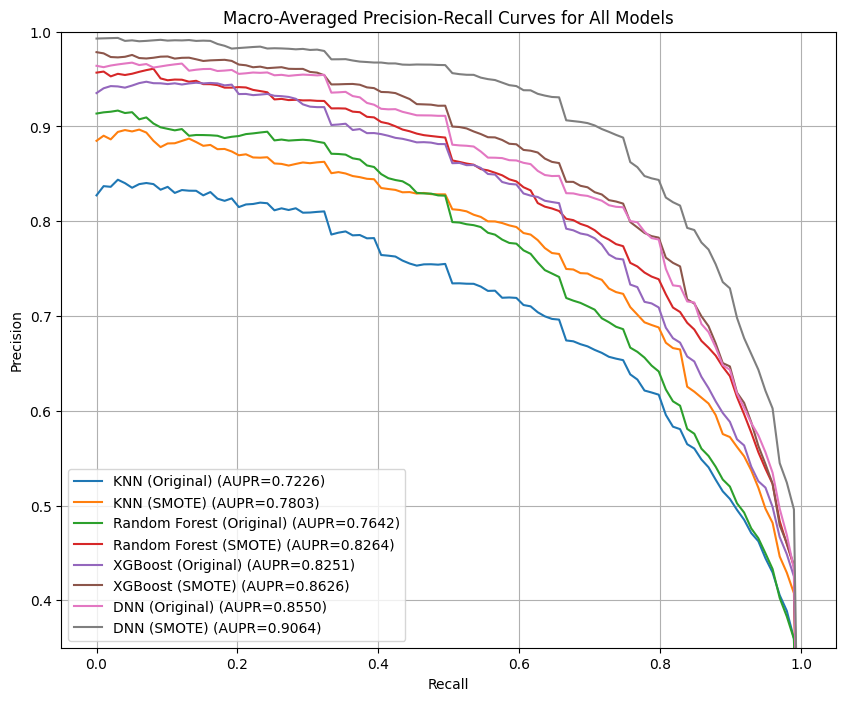

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Step 1: Define model files
model_files = {
    'KNN (Original)': '/content/KNN_original (1).pkl',
    'KNN (SMOTE)': '/content/KNN_SMOTE (1).pkl',
    'Random Forest (Original)': '/content/RF original (1).pkl',
    'Random Forest (SMOTE)': '/content/RF SMOTE (1).pkl',
    'XGBoost (Original)': '/content/XGBOOST original (1).pkl',
    'XGBoost (SMOTE)': '/content/XGBOOST SMOTE (1).pkl',
    'DNN (Original)': '/content/DNN original.pkl',
    'DNN (SMOTE)': '/content/DNN SMOTE.pkl'
}

# Step 2: Helper function to load and process each model
def load_and_process(pkl_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    y_true = np.array(data['y_true'])
    y_pred_prob = np.array(data['y_pred_prob'])
    num_classes = y_pred_prob.shape[1]
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    return y_true_bin, y_pred_prob

# Step 3: Plot PR Curves
plt.figure(figsize=(10, 8))

for model_name, file_path in model_files.items():
    y_true_bin, y_pred_prob = load_and_process(file_path)
    num_classes = y_pred_prob.shape[1]

    # Interpolate precision-recall curves for each class
    recalls = np.linspace(0, 1, 100)
    interpolated_precisions = []

    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
        interpolated = np.interp(recalls, recall[::-1], precision[::-1], left=0, right=0)
        interpolated_precisions.append(interpolated)

    # Macro-average across classes
    mean_precision = np.mean(interpolated_precisions, axis=0)
    pr_auc = average_precision_score(y_true_bin, y_pred_prob, average='macro')

    # Plot
    plt.plot(recalls, mean_precision, label=f"{model_name} (AUPR={pr_auc:.4f})")

# Step 4: Final plot settings
plt.ylim(0.35, 1.0)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-Averaged Precision-Recall Curves for All Models')
plt.legend()
plt.grid(True)
plt.show()


Confusion Pairs


✅ Plotting normalized confusion matrix for: DNN (Original)


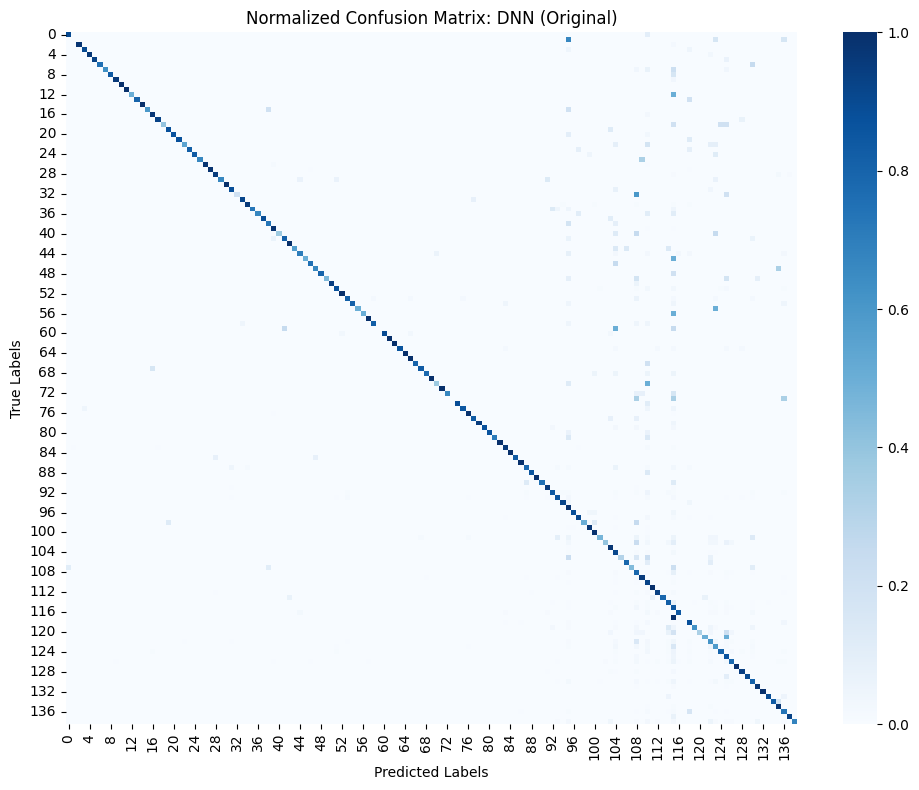


🔎 Top 10 most confused pairs for DNN (Original):
True label 108 predicted as 115: 127 times
True label 115 predicted as 108: 89 times
True label 136 predicted as 118: 73 times
True label 123 predicted as 115: 58 times
True label 122 predicted as 108: 52 times
True label 125 predicted as 115: 50 times
True label 115 predicted as 125: 37 times
True label 118 predicted as 136: 34 times
True label 114 predicted as 115: 31 times
True label 115 predicted as 123: 30 times

✅ Plotting normalized confusion matrix for: DNN (SMOTE)


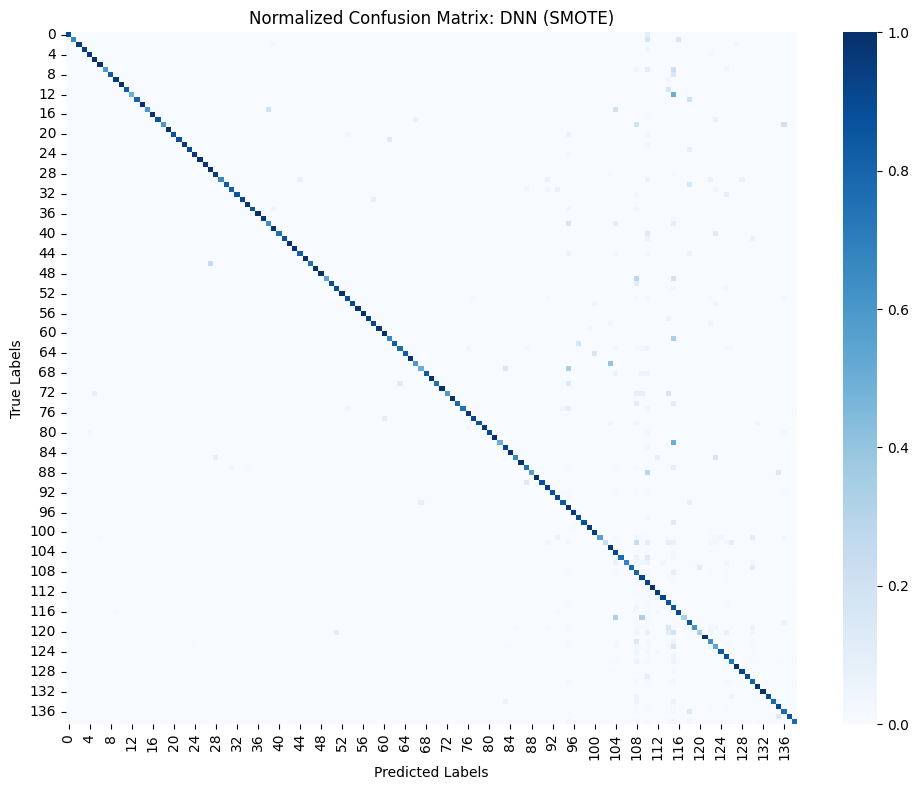


🔎 Top 10 most confused pairs for DNN (SMOTE):
True label 108 predicted as 115: 113 times
True label 115 predicted as 108: 97 times
True label 136 predicted as 118: 62 times
True label 123 predicted as 115: 58 times
True label 118 predicted as 136: 54 times
True label 122 predicted as 108: 52 times
True label 125 predicted as 115: 47 times
True label 115 predicted as 125: 45 times
True label 115 predicted as 110: 34 times
True label 110 predicted as 115: 29 times


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Only DNN models
model_files = {
    'DNN (Original)': '/content/DNN original.pkl',
    'DNN (SMOTE)': '/content/DNN SMOTE.pkl'
}

def load_ytrue_ypred(pkl_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    y_true = np.array(data['y_true'])
    y_pred_prob = np.array(data['y_pred_prob'])
    y_pred = np.argmax(y_pred_prob, axis=1)
    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    # Normalize
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=False, cmap='Blues', cbar=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Normalized Confusion Matrix: {model_name}')
    plt.tight_layout()
    plt.show()

def show_top_misidentifications(y_true, y_pred, model_name, top_n=10):
    cm = confusion_matrix(y_true, y_pred)
    labels = np.arange(cm.shape[0])

    # Zero out the diagonal (correct predictions) to focus on misidentifications
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    # Find top misidentified entries
    top_indices = np.dstack(np.unravel_index(np.argsort(cm_no_diag.ravel())[::-1], cm.shape))[0]

    print(f"\n🔎 Top {top_n} most confused pairs for {model_name}:")
    for i in range(min(top_n, len(top_indices))):
        true_label, pred_label = top_indices[i]
        count = cm[true_label, pred_label]
        if count > 0:
            print(f"True label {true_label} predicted as {pred_label}: {count} times")

# Run for both DNN models
for model_name, file_path in model_files.items():
    y_true, y_pred = load_ytrue_ypred(file_path)
    print(f"\n✅ Plotting normalized confusion matrix for: {model_name}")
    plot_confusion_matrix(y_true, y_pred, model_name)
    show_top_misidentifications(y_true, y_pred, model_name, top_n=10)  # change to 20 if you want


115 The metabolism of Drug B can be decreased when combined with Drug A.

108 The metabolism of Drug A can be decreased when combined with Drug B.

136 The therapeutic efficacy of Drug A can be decreased when used in combination with Drug B.

118 The therapeutic efficacy of Drug B can be decreased when used in combination with Drug A.

123 The serum concentration of Drug B can be increased when it is combined with Drug A.

122 The serum concentration of Drug A can be increased when it is combined with Drug B.

125 Drug A may decrease the excretion rate of Drug B which could result in a higher serum level.

Confusion Matrix

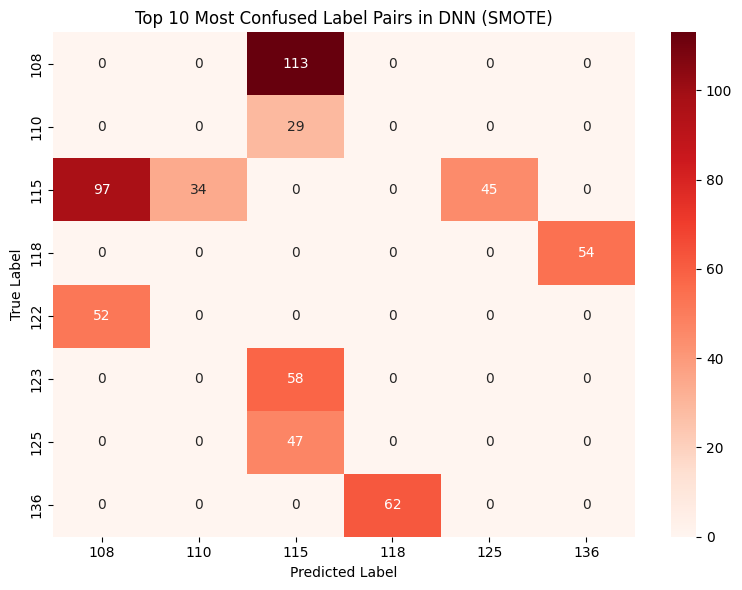

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#  Step 1: Manually input the confusion pairs
confusion_data = [
    (108, 115, 113),
    (115, 108, 97),
    (136, 118, 62),
    (123, 115, 58),
    (118, 136, 54),
    (122, 108, 52),
    (125, 115, 47),
    (115, 125, 45),
    (115, 110, 34),
    (110, 115, 29)
]

# Step 2: Create a DataFrame
df_conf = pd.DataFrame(confusion_data, columns=['True Label', 'Predicted Label', 'Count'])

# Step 3: Pivot table for heatmap
heatmap_data = df_conf.pivot(index='True Label', columns='Predicted Label', values='Count').fillna(0)

# Step 4: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='Reds')
plt.title('Top 10 Most Confused Label Pairs in DNN (SMOTE)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
